In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
from plot import plot

from otf import optim
from otf import time_integration as ti
from otf.syncd import utils
from otf.system import System_ModelKnown

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([-2, 0], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    a, b, c, d = gs

    x, y = true

    return jnp.array([a * y, b * x + c * y * jnp.cos(d * x)])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    b0, a1, c1, d1, a0, b1, c0, d0, e0, e1, f0, f1, g0, g1 = cs

    x, y = nudged

    return jnp.array(
        [
            a0 * x
            + b0 * y
            # + c0 * y * jnp.cos(d0 * x)
            # + e0 * x * jnp.cos(f0 * y)
            + g0,
            a1 * x
            + b1 * y
            + c1 * y * jnp.cos(d1 * x)
            # + e1 * x * jnp.cos(f1 * y)
            + g1,
        ]
    )


# System evolution parameters
g1, g2, g3, g4 = 1, -1, 0.1, 0.75
c1, c2, c3 = g1, g2, g3
mu = 10

gs = jnp.array([g1, g2, g3, g4])
bs = jnp.array([])
cs = 0.5 * jnp.ones(14)

observed_slice = jnp.s_[:]

# prune = False
# if prune:
#     HarmonicOscillator_Pruned = base_optim.pruned_factory(
#         harmonic_oscillator.HarmonicOscillator
#     )
#     threshold = np.full(14, 0.05)  # In this case could set `threshold = 0.05`.
#     iterations = np.full(14, 10)  # Or here `iterations = 10`.

#     system = HarmonicOscillator_Pruned(
#         μ,
#         gs,
#         bs,
#         cs,
#         observed_slice,
#         threshold=threshold,
#         iterations=iterations,
#     )
# else:
system = System_ModelKnown(
    mu, gs, bs, cs, observed_slice, assimilated_ode, true_ode
)

solver = ti.RK4(system)

optimizer = optax.adam(1e-1)
optimizer = optim.OptaxWrapper(system, optimizer)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 100
t_relax = 1

return_all = True
cs, u_errors, tls, true, nudged = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(),
    optimizer=optimizer,
    return_all=return_all,
)
tls_all = np.arange(len(true)) * dt

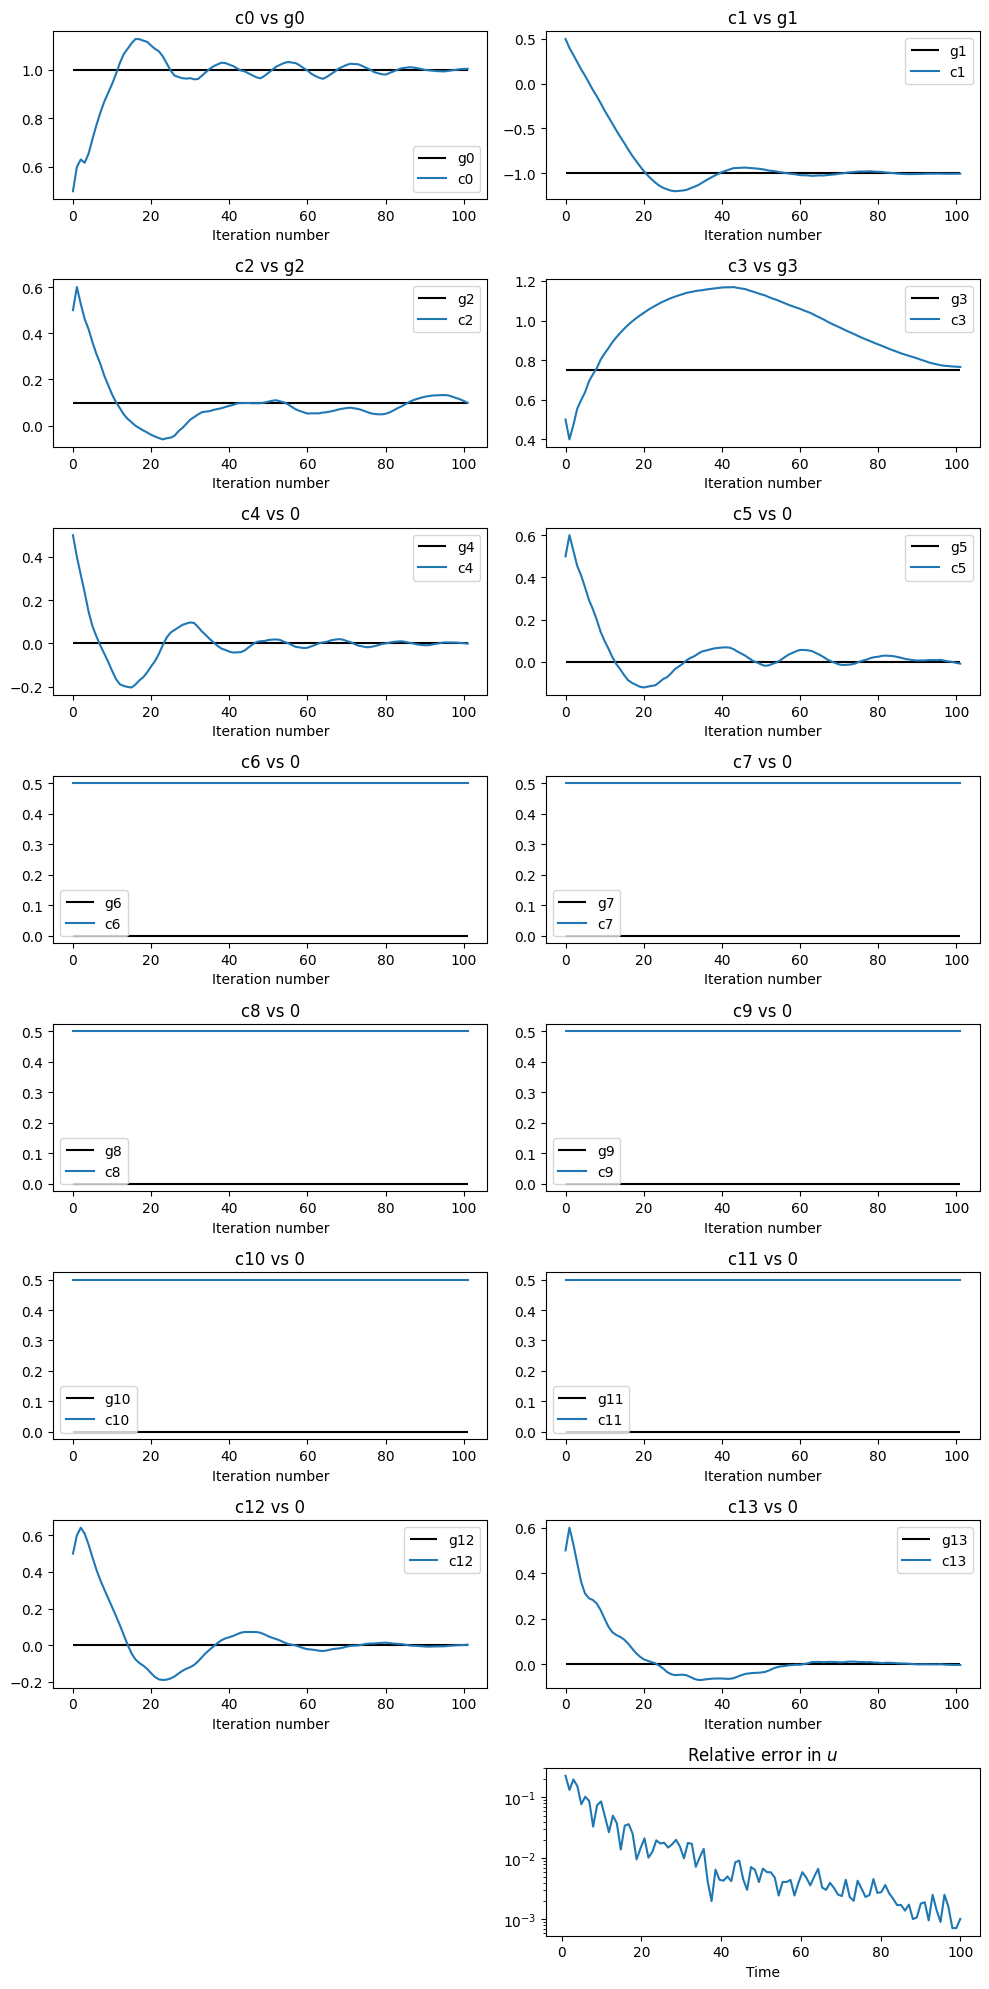

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
plt.show()

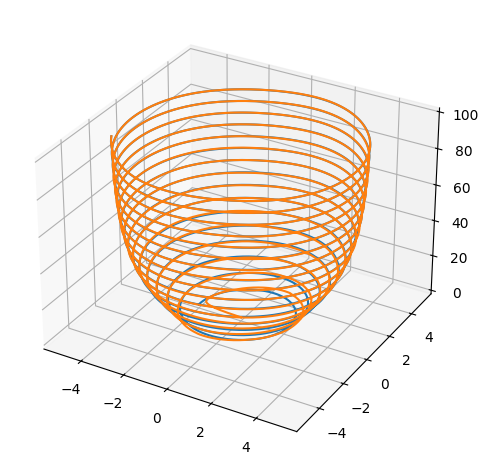

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})

ax.plot(*true.T, tls_all)
ax.plot(*nudged.T, tls_all)

fig.tight_layout()
plt.show()